# Maximum Likelihood Estimation
This script provides an implementation of simple maximum likelihood estimation. There is no further explanation needed. This script really only serves as a means to directly compare against SVI as detailed in svicnn.ipynb.
As such, a simple CNN is implemented below with the exact same architecture as in the corresponding SVI script.

## Import some necessary packages

In [1]:
import tqdm
import torch
import numpy as np
import torch.nn as nn

from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from util.dataset import make_mnist
from model.vicnn import VICNN, ELBO
from torch.optim import Adam
from torch.utils.data import DataLoader
from util.util import show_images

## Building a frequentist CNN
We know all of this...

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.linear1 = nn.Linear(512, 128)
        self.linear2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        x = nn.functional.relu(nn.functional.max_pool2d(x, 2))
        x = x.view(-1, 512)
        x = nn.functional.relu(self.linear1(x))
        x = self.linear2(x)
        return nn.functional.log_softmax(x, dim=-1)

## Train the model on MNIST
Let's train our frequentist model on the MNIST dataset. To show off some special feature of Bayesian Networks, we exclude a class from the train dataset and see later how the model reacts to it.

In [3]:
# Training settings
epochs = 10
lr = 5e-3
filtered_class = 5
batch_size = 64
train, test = make_mnist(filteredClass=filtered_class)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

# Initialize the model and set up ELBO as the loss function
model = CNN()
loss_fn = torch.nn.NLLLoss()
optimizer = Adam(model.parameters(), lr=lr)
optimizer.zero_grad()

# Start the training loop
for epoch in np.arange(epochs):
    for images, labels in (
        pbar := tqdm.tqdm(train_loader, total=len(train) // batch_size)
    ):
        pred = model(images)
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"E={epoch} L={loss.detach():0.6f}")

E=0 L=0.101531: : 853it [00:07, 108.45it/s]                       
E=1 L=0.047129: : 853it [00:08, 105.46it/s]                       
E=2 L=0.030655: : 853it [00:08, 105.17it/s]                       
E=3 L=0.093635: : 853it [00:08, 106.55it/s]                       
E=4 L=0.024342: : 853it [00:08, 104.99it/s]                       
E=5 L=0.000447: : 853it [00:07, 107.01it/s]                       
E=6 L=0.028121: : 853it [00:07, 109.17it/s]                       
E=7 L=0.000375: : 853it [00:07, 108.14it/s]                       
E=8 L=0.001553: : 853it [00:08, 105.97it/s]                       
E=9 L=0.000032: : 853it [00:07, 108.42it/s]                       


## Visualize results
Let's run the network on some test data samples and see what predictions it produces. When querying the frequentist network for a class it had never seen during training, it will still tend to output scores with high confidence for just some class.

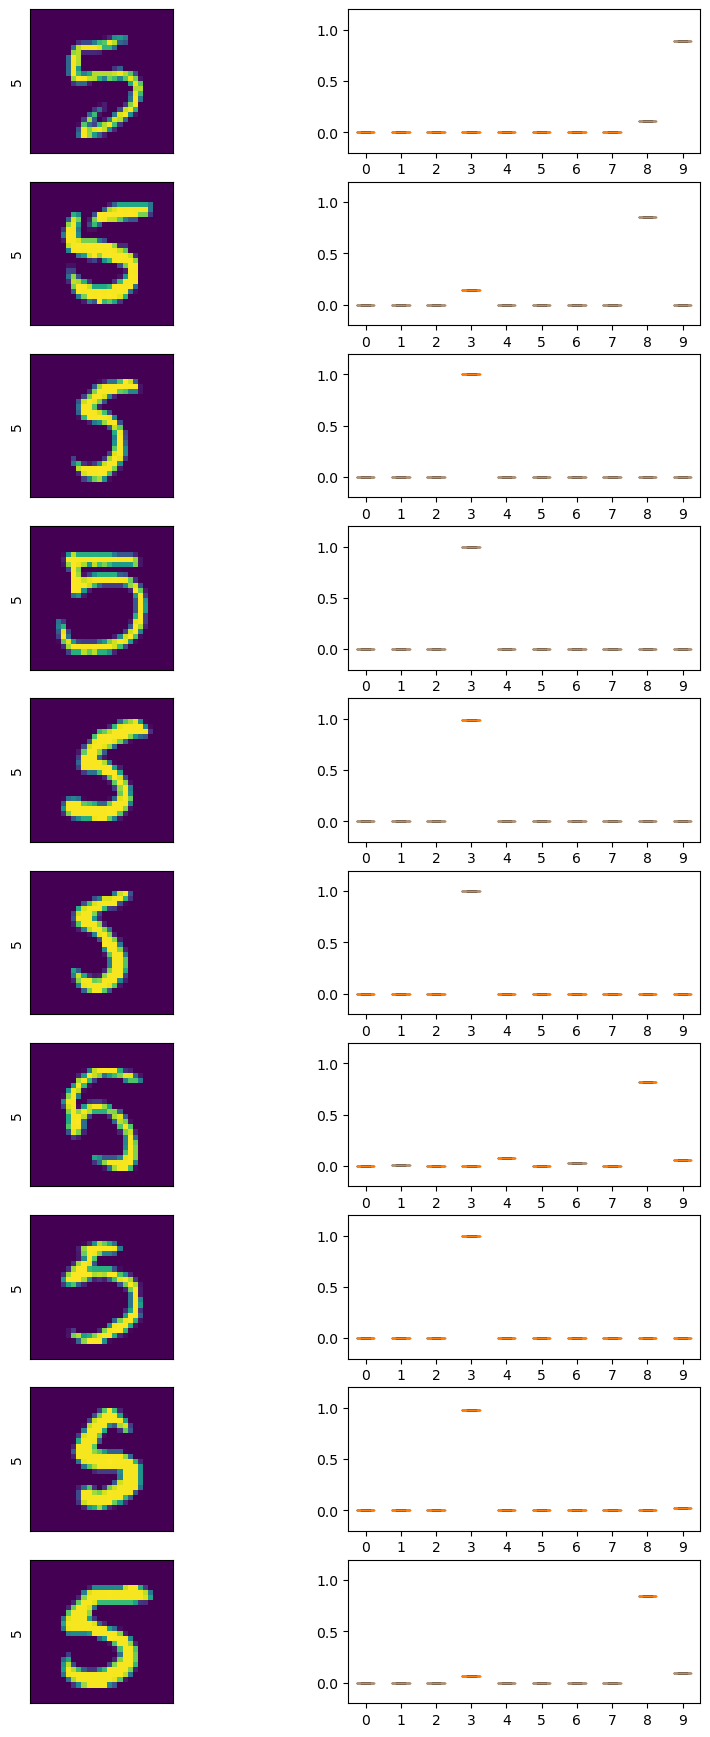

In [4]:
# Pick n test images and sample each num_samples times
# To select only a certain class, assign filter_class the corresponding number
n = 10
filter_class = 5

_, test = make_mnist()
if filter_class is not None:
    indices = np.where(test.targets == filter_class)[0]
    test = torch.utils.data.Subset(test, indices)

test_loader = torch.utils.data.DataLoader(test, batch_size=n, shuffle=True)
samples = torch.zeros((1, n, 10))
images, labels = next(iter(test_loader))

with torch.no_grad():
    samples[0, :, :] = torch.exp(model(images))

# Show the images with their predictions, means and variances
images = images.squeeze()
samples = samples.transpose(1, 0)
show_images(images, samples, labels)